In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
from datetime import date
from datetime import datetime
import numpy as np

from summer.utils import ref_times_to_dti

from autumn.tools.inputs.demography.queries import get_population_by_agegroup
from autumn.models.covid_19.detection import create_cdr_function
from autumn.tools.utils.utils import apply_moving_average
from autumn.tools.curve.scale_up import scale_up_function
from autumn.tools.project import get_project
from autumn.settings import Region, Models
from autumn.models.covid_19.constants import AGEGROUP_STRATA, BASE_DATETIME
from autumn.models.covid_19.mixing_matrix.macrodistancing import weight_mobility_data
from autumn.tools.plots.utils import REF_DATE
from autumn.tools import inputs
from autumn.tools.inputs.database import get_input_db
from autumn.tools.utils.pretty import pretty_print
from autumn.tools.inputs.social_mixing.build_synthetic_matrices import build_synthetic_matrices
from autumn.models.covid_19.detection import get_testing_numbers_for_region

In [2]:
age_integers = [int(group) for group in AGEGROUP_STRATA]
model = Models.SM_SIR
region = Region.COXS_BAZAR

## Population

total modelled population of coxs_bazar is: 918.83 thousand


Text(0.5, 0.98, 'population distribution by age')

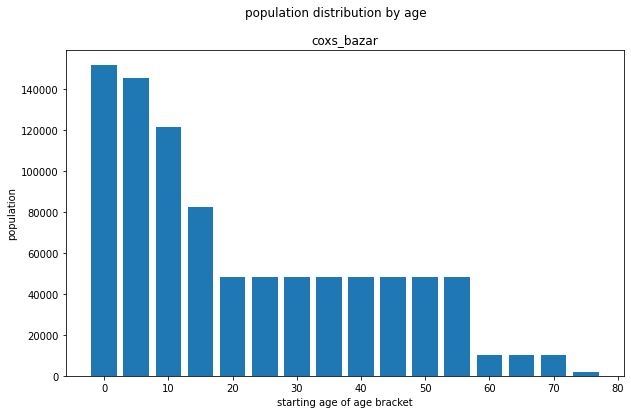

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
project = get_project(model, region)
total_pops = inputs.get_population_by_agegroup(
    AGEGROUP_STRATA, 
    project.param_set.baseline["country"]["iso3"],
    "FDMN", 
    year=project.param_set.baseline["population"]["year"]
)
print(f"total modelled population of {region} is: {round(sum(total_pops) / 1e3, 3)} thousand")
ax.bar(age_integers, total_pops, width=4)
ax.set_title(region)
ax.set_ylabel("population")
ax.set_xlabel("starting age of age bracket")
fig.suptitle("population distribution by age")

## Mobility
### Mobility is only available at the national level, not for Cox's Bazar or FDMNs

In [4]:
print("Whether the mobility effects are actually turned on at all:")
project.param_set.baseline["is_dynamic_mixing_matrix"]

Whether the mobility effects are actually turned on at all:


False

(18262.0, 19026.0)

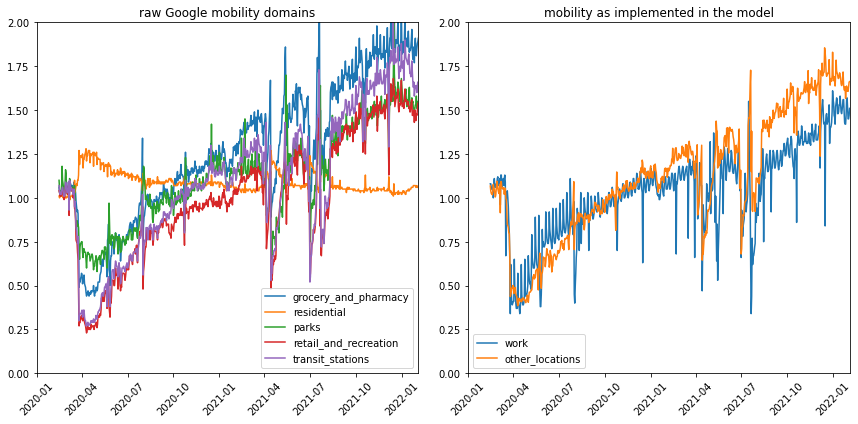

In [5]:
y_upper = 2.

# Collate data together
input_db = get_input_db()
mob_df = input_db.query("mobility", conditions={"iso3": "BGD"})
times = [datetime.strptime(i, "%Y-%m-%d") for i in mob_df["date"]]
google_mob_df = weight_mobility_data(mob_df, project.param_set.baseline["mobility"]["google_mobility_locations"])

# Get plots ready
mob_fig, mob_axes = plt.subplots(1, 2, figsize=(12, 6))
plot_left_date = date(2020, 1, 1)
plot_right_date = times[-1]  # Not sure why this is necessary

# Plot raw mobility data
ax = mob_axes[0]
for mobility_domain in ["grocery_and_pharmacy", "residential", "parks", "retail_and_recreation", "transit_stations"]:
    ax.plot(times, mob_df[mobility_domain], label=mobility_domain)
ax.set_ylim((0., y_upper))
ax.tick_params(axis="x", labelrotation=45)
ax.set_title("raw Google mobility domains")
ax.legend(loc="lower right")
ax.set_xlim(left=plot_left_date, right=plot_right_date)

# Plot processed mobility data
ax = mob_axes[1]
for location in list(project.param_set.baseline["mobility"]["google_mobility_locations"].keys()):
    ax.plot(times, google_mob_df[location], label=location)
ax.tick_params(axis="x", labelrotation=45)
ax.set_ylim((0., y_upper))
ax.legend(loc="lower left")
ax.set_title("mobility as implemented in the model")
mob_fig.tight_layout(w_pad=1.5, h_pad=3.5)
ax.set_xlim(left=plot_left_date, right=plot_right_date)


## Mixing matrix
### Check how mixing matrix is specified for each region

In [6]:
print(f"Modelled country: {project.param_set.baseline['country']['iso3']}")
print(f"Modelled sub-region: {project.param_set.baseline['population']['region']}")
print(f"Proxy country: {project.param_set.baseline['ref_mixing_iso3']}")
print("Always age-adjusted under SM-SIR code")

Modelled country: BGD
Modelled sub-region: FDMN
Proxy country: HKG
Always age-adjusted under SM-SIR code


### Display the matrix and the matrix components

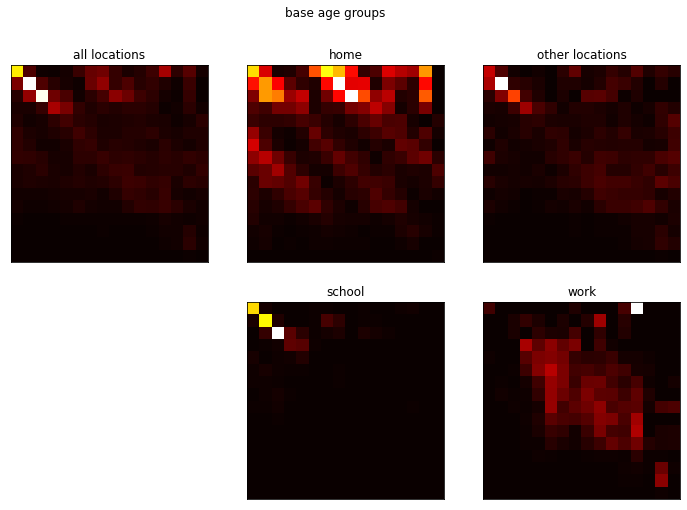

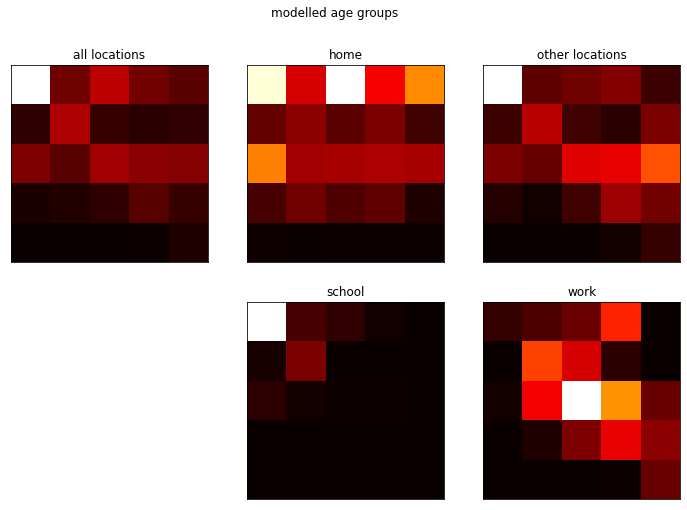

In [7]:
agegroup_types = {
    "base age groups": AGEGROUP_STRATA,
    "modelled age groups": project.param_set.baseline["age_groups"],
}

for title, agegroups in agegroup_types.items():

    mixing_matrix = build_synthetic_matrices(
        project.param_set.baseline["country"]["iso3"],
        project.param_set.baseline["ref_mixing_iso3"],
        agegroups,
        True,
        project.param_set.baseline["population"]["region"]
    )

    fig = plt.figure(figsize=(12, 8))
    positions = [1, 2, 3, 5, 6]
    for i_loc, location in zip(positions, mixing_matrix.keys()):
        ax = fig.add_subplot(2, 3, i_loc)
        ax.imshow(
            np.flipud(np.transpose(mixing_matrix[location])), 
            cmap=cm.hot, 
            vmin=0,
            vmax=mixing_matrix[location].max(), 
            origin="lower"
        )
        ax.set_title(location.replace("_", " "))
        ax.set_xticks([])
        ax.set_yticks([])
    fig.suptitle(title)

## Case detection

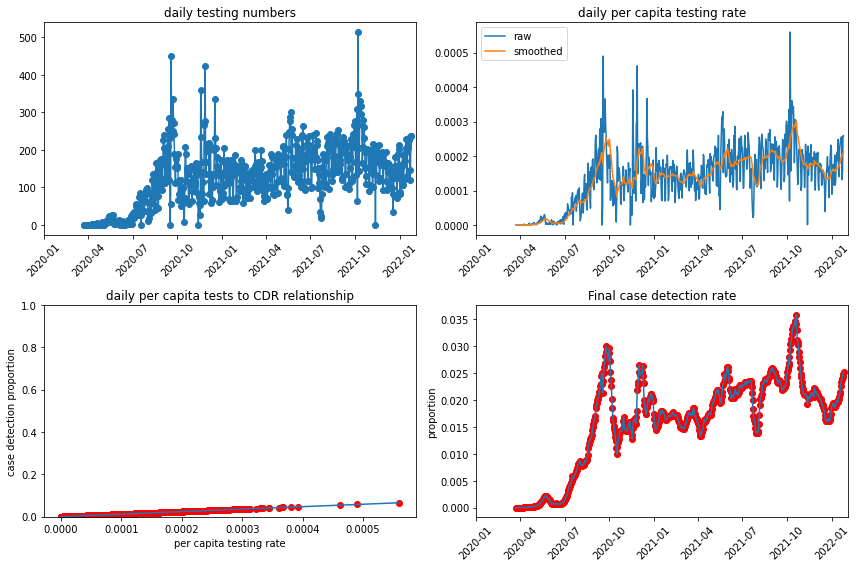

In [8]:
# Get the CDR function of tests
cdr_from_tests_func = create_cdr_function(
    project.param_set.baseline["testing_to_detection"]["assumed_tests_parameter"],
    project.param_set.baseline["testing_to_detection"]["assumed_cdr_parameter"],
)

# Get the denominator population
testing_pops = get_population_by_agegroup(
    project.param_set.baseline["age_groups"],
    project.param_set.baseline["country"]["iso3"],
    project.param_set.baseline["population"]["region"]
)

# Process the data
test_times, test_values = get_testing_numbers_for_region("BGD", "FDMN")
test_dates = ref_times_to_dti(BASE_DATETIME, [int(time) for time in test_times])
per_capita_tests = [i_tests / sum(testing_pops) for i_tests in test_values]
dummy_tests = np.linspace(0, max(per_capita_tests), 200)
if project.param_set.baseline["testing_to_detection"]["assumed_tests_parameter"]:
    smoothed_per_capita_tests = apply_moving_average(
        per_capita_tests, 
        project.param_set.baseline["testing_to_detection"]["smoothing_period"]
    )
else:
    smoothed_per_capita_tests = per_capita_tests
cdr_function_of_time = scale_up_function(
    test_times,
    [cdr_from_tests_func(test_rate) for test_rate in smoothed_per_capita_tests],
    smoothness=0.2, method=4, bound_low=0.,
)    

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(w_pad=1.5, h_pad=5)

def sort_axis_dates(ax):
    axis.tick_params(axis="x", labelrotation=45)
    axis.set_xlim(left=plot_left_date, right=plot_right_date)

# Plot daily number of tests
axis = axes[0, 0]
axis.plot(test_dates, test_values, marker="o")
axis.set_title("daily testing numbers")
sort_axis_dates(axis)

# Plot daily number of tests
axis = axes[0, 1]
axis.plot(test_dates, per_capita_tests, label="raw")
axis.plot(test_dates, smoothed_per_capita_tests, label="smoothed")
axis.set_title("daily per capita testing rate")
sort_axis_dates(axis)
axis.legend()

# Plot relationship of daily tests to CDR proportion
axis = axes[1, 0]
axis.plot(dummy_tests, cdr_from_tests_func(dummy_tests))
axis.scatter(per_capita_tests, [cdr_from_tests_func(i_tests) for i_tests in per_capita_tests], color="r")
axis.set_ylabel("case detection proportion")
axis.set_xlabel("per capita testing rate")
axis.set_title("daily per capita tests to CDR relationship")
axis.set_ylim(top=1.)

# Plot CDR values
axis = axes[1, 1]
axis.scatter(test_dates, [cdr_from_tests_func(i_test_rate) for i_test_rate in smoothed_per_capita_tests], color="r")
axis.plot(test_dates, [cdr_function_of_time(time) for time in test_times])
axis.set_title("Final case detection rate")
axis.set_ylabel("proportion")
sort_axis_dates(axis)

fig.tight_layout()